# Pre trained networks

![imagen](https://www.researchgate.net/publication/336874848/figure/fig1/AS:819325225144320@1572353764073/Illustrations-of-transfer-learning-a-neural-network-is-pretrained-on-ImageNet-and.png)

Hemos visto cómo creábamos modelos desde 0. Sin embargo, no siempre se hace eso, sino que en muchos casos es posible reutilizar parte de todo ese trabajo que se ha diseñado para adaptarlo a un nuevo caso de uso. Se trata de las redes preentrenadas.

Las arquitecturas de redes neuronales complejas más utilizadas en la comunidad son las siguientes (de las cuáles puedes profundizar en la extensa literatura de Internet):
* VGG-16
* VGG-19
* Inception V3
* XCeption
* ResNet-50

Estas redes las podemos incorporar tanto entrenadas como sin entrenar. Y es aquí donde entra este notebook. A continuación, veremos las diferentes implementaciones de algunas de ellas y cómo podemos hacer esa transferencia de conocimiento de las redes ya entrenadas a un nuevo dataset.

## ResNet50V2

Como red extensamente utilizada que es, tensorflow ya la tiene incorporada de manera nativa. Además, al especificar ``weights='imagenet'`` le estamos diciendo que tome los valores de la red preentrenada con el dataset de ImageNet, por lo que la primera vez descargará el modelo original y lo importará:

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import cv2

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

In [5]:
# image-net.org
base_model = ResNet50V2(input_shape=(224, 224, 3),
                       include_top=True,
                       weights='imagenet',
                       classifier_activation='softmax')

In [6]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Carguemos algunas imagenes desde local, para ver qué tal funciona la red ResNet50V2 ya entrenada.

In [7]:
import os


def read_data(path):
    X = []

    for file in os.listdir(path):
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (224, 224))
        print(path + '/' + file)
        X.append(smallimage)

    return np.array(X)

x_test = read_data('img')

# Procesar las imagenes tal y como entran en el modelo
x_test = preprocess_input(x_test)
print(x_test.shape)

img/bear-1.jpg
img/cat.8016.jpg
img/cat.8037.jpg
img/dog.11856.jpg
img/dog.11857.jpg
img/horse.jpg
img/karate.jpg
img/pizza.jpg
(8, 224, 224, 3)


In [24]:
preds = base_model.predict(x_test)

decodes = decode_predictions(preds, top=5)

for cont, i in enumerate(decodes):
    print('############')
    
    for j, decode in enumerate(i):
        print('Predicted:\n', decode[1], decode[2])

############
Predicted:
 brown_bear 0.99944514
Predicted:
 chow 0.000541394
Predicted:
 American_black_bear 8.784533e-06
Predicted:
 ice_bear 1.1080914e-06
Predicted:
 howler_monkey 4.4057327e-07
############
Predicted:
 Egyptian_cat 0.6597232
Predicted:
 Siamese_cat 0.15741065
Predicted:
 tiger_cat 0.062600076
Predicted:
 lynx 0.02283658
Predicted:
 tabby 0.018356167
############
Predicted:
 Egyptian_cat 0.82118607
Predicted:
 lynx 0.1293218
Predicted:
 Siamese_cat 0.021827238
Predicted:
 tabby 0.01832458
Predicted:
 tiger_cat 0.0067972774
############
Predicted:
 Rottweiler 0.76189584
Predicted:
 Brabancon_griffon 0.074613586
Predicted:
 Staffordshire_bullterrier 0.028572522
Predicted:
 EntleBucher 0.019904176
Predicted:
 Doberman 0.019285055
############
Predicted:
 collie 0.99525565
Predicted:
 Shetland_sheepdog 0.004744308
Predicted:
 yellow_lady's_slipper 9.7512345e-09
Predicted:
 goldfinch 8.175372e-09
Predicted:
 groenendael 7.4755615e-09
############
Predicted:
 standard_poodl

## VGG16
En este caso vamos a importar la red VGG16, que utilizaremos como red preentrenada y completaremos con una fully connected layer.

En este apartado, veremos muchos pasos que quizás nos líen un poco, pero en este caso hay que hacer más bien dogma de fe y replicarlo/adaptarlo cuando lo volvamos a utilizar, pues son cosas muy particulares de cómo está implementado:

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split

IM_SIZE=64

TRAIN_PATH = "../2-Redes Convolucionales/dogs-vs-cats/mini_data/"

filenames = os.listdir(TRAIN_PATH)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)
    
df = pd.DataFrame({
    'filenames': filenames,
    'category': categories
})

train_df, test_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

train_df, validate_df = train_test_split(train_df,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [58]:
df.head()

,filenames,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


En este punto vamos a introducir una herramienta muy interesante de Keras: el ImageDataGenerator.

¿Y qué nos aporta eso?, pensarás. Pues cuando disponemos de pocos datos de entrenamiento, es un problema aprender de esos datos. Y cuando estamos hablando de imágenes es algo mucho peor, ya que es un factor crítico. En este caso, Keras nos proporciona una opción de aumentar nuestras muestras de entrenamiento, ya que puede hacerle pequeñas modificaciones a cada imagen y considerarlas como imágenes diferentes.

Estas modificaciones son, por ejemplo, como las que se muestran en la siguiente imagen:

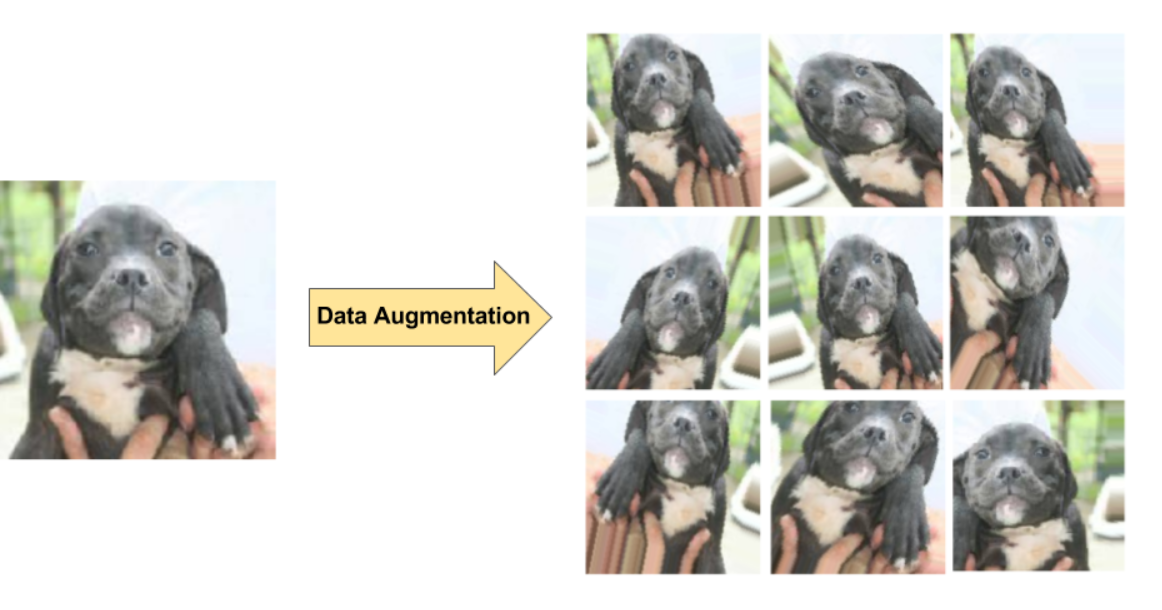

Además, también se encarga de adaptar el tamaño de todas las imágenes al mismo formato, facilitando el futuro tratamiento de datos.

In [59]:
from keras.preprocessing.image import ImageDataGenerator


# Al añadir estos parámetros, conseguimos establecer ese "data-augmentation":
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Sin embargo, los datos de validación no debemos aumentarlos, pues estaríamos distorsionando su naturaleza generalista para evaluar el proceso de entrenamiento:
validation_datagen = ImageDataGenerator(rescale = 1.0/255. )

Y una vez lo hemos definido, los utilizaremos para crearnos los generadores mediante el método ``flow_from_dataframe`` de los objetos que nos acabamos de crear. Estos 'generadores' podrán ser usados en el futuro:

In [60]:
# Usaremos 
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    TRAIN_PATH,
                                                    x_col='filenames',
                                                    y_col='category',
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (IM_SIZE, IM_SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              TRAIN_PATH,
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (IM_SIZE, IM_SIZE))

Found 3840 validated image filenames belonging to 2 classes.
Found 961 validated image filenames belonging to 2 classes.
Found 1201 validated image filenames belonging to 2 classes.


In [47]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (IM_SIZE, IM_SIZE, 3),
                  include_top = False,
                  weights = 'imagenet')

# Modificamos las capas para que no sean entrenables, ya que solo queremos entrenar nuestra última capa
for layer in base_model.layers:
    layer.trainable = False
    
# Añadimos esta capa extra totalmente conectada:
# Empezamos con una capa Flatten que nos reduzca a 1D. Observa que la sintaxis cambia, no es un simple 'add':
x = layers.Flatten()(base_model.output)

# Añadimos la capa densa que comentábamos, donde ahora tendremos que hacerlo del siguiente método:
x = layers.Dense(512, activation='relu')(x)

# Además, vamos a añadir una capa de dropout, que hemos comentado en clase:
x = layers.Dropout(0.5)(x)

# Añadimos la capa final, que será de 1 neurona por ser un problema de clasificación binaria:
x = layers.Dense(1, activation='sigmoid')(x)

# Componemos el modelo:
model = tf.keras.models.Model(base_model.input, x)

# Configuración:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [48]:
# Y entrenamos el modelo con los generadores anteriores:
vgghist = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 5)

Epoch 1/5
241/241 [==============================] - 124s 512ms/step - loss: 0.6871 - accuracy: 0.6440 - val_loss: 0.4883 - val_accuracy: 0.7635
Epoch 2/5
241/241 [==============================] - 126s 524ms/step - loss: 0.5522 - accuracy: 0.7109 - val_loss: 0.5109 - val_accuracy: 0.7211
Epoch 3/5
241/241 [==============================] - 128s 530ms/step - loss: 0.5383 - accuracy: 0.7257 - val_loss: 0.4821 - val_accuracy: 0.7560
Epoch 4/5
241/241 [==============================] - 128s 533ms/step - loss: 0.5203 - accuracy: 0.7461 - val_loss: 0.4945 - val_accuracy: 0.7402
Epoch 5/5
241/241 [==============================] - 132s 547ms/step - loss: 0.5188 - accuracy: 0.7393 - val_loss: 0.4533 - val_accuracy: 0.7777


#### Prediciendo:

In [61]:
test_datagen = ImageDataGenerator(rescale = 1.0/255. )

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                              TRAIN_PATH,
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (IM_SIZE, IM_SIZE))

Found 1201 validated image filenames belonging to 2 classes.


In [64]:
preds = vgghist.model.predict(test_generator)

In [72]:
umbral = 0.5
class_preds = preds[:, 0] > umbral
pd.Series(class_preds).value_counts()

False    602
True     599
dtype: int64

In [74]:
model.evaluate(test_generator) 

61/61 [==============================] - 23s 381ms/step - loss: 0.4533 - accuracy: 0.7777


[0.45327043533325195, 0.777685284614563]

#### Si tenemos los datos en otra localización:

Mientras tengamos etiquetados los datos, no hay problema. Aquí dejo un ejemplo muy sencillo con solo 2 fotos para test:

In [80]:
test_df2 = pd.DataFrame({'filenames': ['4.jpg', '11.jpg'], 'category': ['dog', 'cat']})

In [81]:
TEST_PATH = '../2-Redes Convolucionales/dogs-vs-cats/test/'

test_datagen2 = ImageDataGenerator(rescale = 1.0/255. )

test_generator2 = test_datagen.flow_from_dataframe(test_df2,
                                                   TEST_PATH,
                                                   x_col='filenames',
                                                   y_col='category',
                                                   class_mode = 'binary',
                                                   target_size = (IM_SIZE, IM_SIZE))

Found 2 validated image filenames belonging to 2 classes.


In [82]:
model.evaluate(test_generator2)

1/1 [==============================] - 0s 78ms/step - loss: 0.0988 - accuracy: 1.0000


[0.09878228604793549, 1.0]

## ResNet50V2 sin entrenar

In [16]:
IM_SIZE=32

# Entrono todo de 0
base_model = ResNet50V2(input_shape=(IM_SIZE, IM_SIZE, 3),
                        include_top=False)

# Entreno todo, partiendo de la convolucional entrenada
base_model = ResNet50V2(input_shape=(IM_SIZE, IM_SIZE, 3),
                        include_top=False,
                        weights='imagenet')

In [17]:
# train_generator con batches de 20:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    TRAIN_PATH,
                                                    x_col='filenames',
                                                    y_col='category',
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (IM_SIZE, IM_SIZE))

# generador de validación del mismo batch_size que train:
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              TRAIN_PATH,
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (IM_SIZE, IM_SIZE))

Found 5260 validated image filenames belonging to 2 classes.
Found 1316 validated image filenames belonging to 2 classes.


Ahora, al igual que antes, podríamos ir añadiendo capas a la red ya diseñada. Sin embargo, también podríamos partir del modelo que nos hemos cargado sin entrenar y proceder con los datos que tenemos, lo cual no haremos aquí debido a que nos llevaría muuuuuuucho tiempo debido a la cantidad de datos y la complejidad de la red:

In [18]:
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [19]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 5)

Epoch 1/5
 28/263 [==>...........................] - ETA: 10:31 - loss: 0.9910 - accuracy: 0.5536

KeyboardInterrupt: 